In [1]:
##All General Import Statements
import pandas as pd
import numpy as np
import math
import random
%matplotlib inline
import random
from matplotlib import pyplot
import os
from datetime import datetime
import warnings

warnings.filterwarnings("ignore")

# Anomaly Detection Algorithms: Isolation Forest vs the Rest

<p>This notebook shows a simplified implementation of the algorithm Isolation Forest and compares its Scikit-learn implementation with other popular anomaly detection algorithms. (KMeans, Local Outlier Factor, One-Class SVM)</p>

<p>In a real world scenario, an unsupervised model is used primarily as a seed to create labelled data unless risk rules based on domain knowledge can be formulated for the problem. For example, if the problem is to identify anomalies in network traffic metrics such as time between logins and distance between origins can be used to formulate a risk rule. Anomalous logins obtained by applying this rule must then be audited to come up with their true labels. On the other hand take the case of identifying the probability of an employee  committing securities fraud. Here the behavioral data that the organization captures is very high dimensional and the relationship between the data points is complex. Hence without indepth domain knowledge, formulating risk rules is difficult.  This combined with issues such as confidentiality makes it very hard to validate these risk rules.</p>

<p>This is where unsupervised learning shines. With very little domain knowledge, a simple unsupervised algorithm can be used to create a list of anomalies which can then be fed into an auditing process which then generates the true labels. Over time when enough data labels are created, the unsupervised problem can be reformulated as a supervised ML problem.</p>

<p>Since this notebook aims to compare various unsupervised algorithms with each other their actual performance needs to be validated. For this I use a labelled dataset. But the algorithms do not see the labels while training. The labels are only used to compare the model predictions to the actual values and to create performance metrics.</p>

## Isolation Forests in Python

Let us now test the algorithm on a test dataset.
Source: https://www.kaggle.com/code/rgaddati/unsupervised-fraud-detection-isolation-forest/data

In [2]:
df=pd.read_csv("data/creditcard.csv")
y_true=df['Class']
df_data=df.drop('Class',1)

In [3]:
from sklearn.ensemble import IsolationForest
from sklearn.svm import OneClassSVM
from sklearn.neighbors import LocalOutlierFactor ## Only available with scikit-learn 0.19 and later
from sklearn.cluster import KMeans

Next, let's create a train and test dataset.

In [4]:
from sklearn.model_selection import train_test_split

In [5]:
X_train, X_test, y_train, y_test = train_test_split(df_data, y_true, test_size=0.3, random_state=42)

Finally, let's create a few helper functions that help with training and testing the models. The preprocess function is not used in this notebook but it might help improve the scores on the KMeans and One Class SVM models.

In [6]:
## Not required for Isolation Forest
def preprocess(df_data):
    for col in df_data:
        df_data[col]=(df_data[col]-np.min(df_data[col]))/(np.max(df_data[col])-np.min(df_data[col]))
    return

<b>Note:</b> The below train and predict functions are designed to output ensemble models (bagged models), with the default size being 5 models. The Isolation Forest and One Class SVM use these functions.

In [7]:
## Not valid for LOF
def train(X,clf,ensembleSize=5,sampleSize=10000):
    mdlLst=[]
    for n in range(ensembleSize):
        X=df_data.sample(sampleSize)
        clf.fit(X)
        mdlLst.append(clf)
    return mdlLst

In [8]:
## Not valif for LOF
def predict(X,mdlLst):
    y_pred=np.zeros(X.shape[0])
    for clf in mdlLst:
        y_pred=np.add(y_pred,clf.decision_function(X).reshape(X.shape[0],))
    y_pred=(y_pred*1.0)/len(mdlLst)
    return y_pred

Finally, let's import some model scoring libraries. Since, we are dealing with a heavily imbalanced dataset, F1 Score is used as a proxy for model performance.

For more details, refer http://scikit-learn.org/stable/modules/generated/sklearn.metrics.f1_score.html

In [9]:
from sklearn.metrics import roc_auc_score
from sklearn.metrics import confusion_matrix,f1_score

#### Isolation Forest

In [10]:
alg=IsolationForest(n_estimators=100, 
                    max_samples='auto', 
                    contamination=0.01,
                    max_features=1.0,
                    bootstrap=False, 
                    n_jobs=-1, 
                    random_state=42,
                    verbose=0)

<b>Note:</b> The magic function timeit does not let us use any variable that is created in the timeit cell. Hence, every cell with a timeit magic function will have a corresponding regular cell with the same code.

In [11]:
start = datetime.now()

if_mdlLst=train(X_train,alg)

finish = datetime.now()

time_exec_if = finish - start
print("Time execution:", time_exec_if)

Time execution: 0:00:03.714569


In [13]:
start = datetime.now()

if_y_pred=predict(X_test,if_mdlLst)
if_y_pred=1-if_y_pred

#Creating class labels based on decision function
if_y_pred_class=if_y_pred.copy()
if_y_pred_class[if_y_pred>=np.percentile(if_y_pred,95)]=1
if_y_pred_class[if_y_pred<np.percentile(if_y_pred,95)]=0

finish = datetime.now()

time_exec_pred_if = finish - start
print("Time execution:", time_exec_pred_if)

Time execution: 0:00:13.055696


In [14]:
roc_auc_score(y_test, if_y_pred_class)

0.9057879792638215

In [15]:
f1_score(y_test, if_y_pred_class)

0.05307325924245861

In [16]:
if_cm=confusion_matrix(y_test, if_y_pred_class)

<AxesSubplot:>

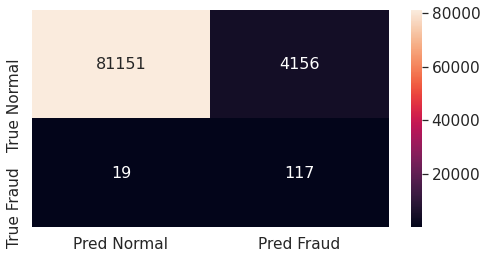

In [17]:
import seaborn as sn
     
df_cm = pd.DataFrame(if_cm,
                  ['True Normal','True Fraud'],['Pred Normal','Pred Fraud'])
pyplot.figure(figsize = (8,4))
sn.set(font_scale=1.4)#for label size
sn.heatmap(df_cm, annot=True,annot_kws={"size": 16},fmt='g')# font size

#### KMeans

The top 5% of the farthest point from cluster centers are itentified as fraud (outliers)

In [18]:
start = datetime.now()

kmeans = KMeans(n_clusters=8, random_state=42,n_jobs=-1).fit(X_train)

finish = datetime.now()

time_exec_km = finish - start
print("Time execution:", time_exec_km)

Time execution: 0:00:06.283201


In [19]:
start = datetime.now()

X_test_clusters=kmeans.predict(X_test)
X_test_clusters_centers=kmeans.cluster_centers_
dist = [np.linalg.norm(x-y) for x,y in zip(X_test.values,X_test_clusters_centers[X_test_clusters])]

km_y_pred=np.array(dist)
km_y_pred[dist>=np.percentile(dist,95)]=1
km_y_pred[dist<np.percentile(dist,95)]=0

finish = datetime.now()

time_exec_pred_km = finish - start
print("Time execution:", time_exec_pred_km)

Time execution: 0:00:00.794345


In [20]:
roc_auc_score(y_test, km_y_pred)

0.5265078067519458

In [21]:
f1_score(y_test, km_y_pred)

0.0063506464050805175

In [22]:
km_cm=confusion_matrix(y_test, km_y_pred)

<AxesSubplot:>

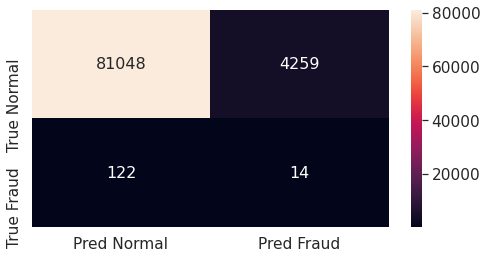

In [23]:
df_cm = pd.DataFrame(km_cm,
                  ['True Normal','True Fraud'],['Pred Normal','Pred Fraud'])
pyplot.figure(figsize = (8,4))
sn.set(font_scale=1.4)#for label size
sn.heatmap(df_cm, annot=True,annot_kws={"size": 16},fmt='g')# font size

#### LOF

Local Outlier Factor only looks at the local neighbourhood of a data point and hence cannot make predictions on out of sample data points. Hence we work directly with X_test here.

In [24]:
clf=LocalOutlierFactor(n_neighbors=20, 
                       algorithm='auto',
                       leaf_size=30, \
                       metric='minkowski',
                       p=2,
                       metric_params=None,
                       contamination=0.1,
                       n_jobs=-1)

In [25]:
start = datetime.now()

clf.fit(X_test)

finish = datetime.now()

time_exec_lof = finish - start
print("Time execution:", time_exec_lof)

Time execution: 0:04:29.055726


In [26]:
start = datetime.now()

lof_y_pred=clf.negative_outlier_factor_

#Creating class labels based on decision function
lof_y_pred_class=lof_y_pred.copy()
lof_y_pred_class[lof_y_pred>=np.percentile(lof_y_pred,95)]=1
lof_y_pred_class[lof_y_pred<np.percentile(lof_y_pred,95)]=0

finish = datetime.now()

time_exec_pred_lof = finish - start
print("Time execution:", time_exec_pred_lof)

Time execution: 0:00:00.003890


In [27]:
roc_auc_score(y_test, lof_y_pred_class)

0.4970491525762661

In [28]:
f1_score(y_test, lof_y_pred_class)

0.0027217056021773644

In [29]:
lof_cm=confusion_matrix(y_test, lof_y_pred_class)

<AxesSubplot:>

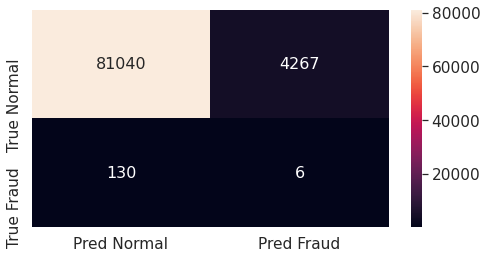

In [30]:
df_cm = pd.DataFrame(lof_cm,
                  ['True Normal','True Fraud'],['Pred Normal','Pred Fraud'])
pyplot.figure(figsize = (8,4))
sn.set(font_scale=1.4)#for label size
sn.heatmap(df_cm, annot=True,annot_kws={"size": 16},fmt='g')# font size

#### One-Class SVM*

##### *Any kernel except linear will take a while. Feel free to grab a coffee, if you decide to change the kernel type

In [31]:
alg=OneClassSVM(kernel='linear',
                gamma='auto', 
                coef0=0.0,
                tol=0.001,
                nu=0.5, \
                shrinking=True,
                cache_size=500,
                verbose=False,
                max_iter=-1)

In [32]:
start = datetime.now()

osvm_mdlLst=train(X_train,alg)

finish = datetime.now()

time_exec_svm = finish - start
print("Time execution:", time_exec_svm)

Time execution: 0:00:15.253225


In [33]:
start = datetime.now()

osvm_y_pred=predict(X_test,osvm_mdlLst)

#Creating class labels based on decision function
osvm_y_pred_class=osvm_y_pred.copy()
osvm_y_pred_class[osvm_y_pred<0]=1
osvm_y_pred_class[osvm_y_pred>=0]=0

finish = datetime.now()

time_exec_pred_svm = finish - start
print("Time execution:", time_exec_pred_svm)

Time execution: 0:01:09.279774


In [34]:
roc_auc_score(y_test, osvm_y_pred_class)

0.5172657974416277

In [35]:
f1_score(y_test, osvm_y_pred_class)

0.003391169024225954

In [36]:
osvm_cm=confusion_matrix(y_test, osvm_y_pred_class)

<AxesSubplot:>

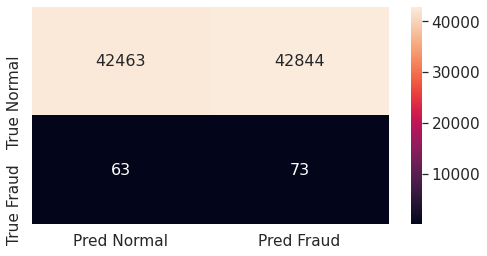

In [37]:
df_cm = pd.DataFrame(osvm_cm,
                  ['True Normal','True Fraud'],['Pred Normal','Pred Fraud'])
pyplot.figure(figsize = (8,4))
sn.set(font_scale=1.4)#for label size
sn.heatmap(df_cm, annot=True,annot_kws={"size": 16},fmt='g')# font size

## Conclusion

In [47]:
## Performance Plot
train_times={
    'Isolation Forest': time_exec_if.total_seconds(),
    'KMeans': time_exec_km.total_seconds(),
    'LOF': time_exec_lof.total_seconds(),
    'OneClass SVM': time_exec_svm.total_seconds()
}

prediction_times={
    'Isolation Forest': time_exec_pred_if.total_seconds(),
    'KMeans': time_exec_pred_km.total_seconds(),
    'LOF': time_exec_pred_lof.total_seconds(),
    'OneClass SVM': time_exec_pred_svm.total_seconds()
}

Text(0.5, 0, 'Time in seconds')

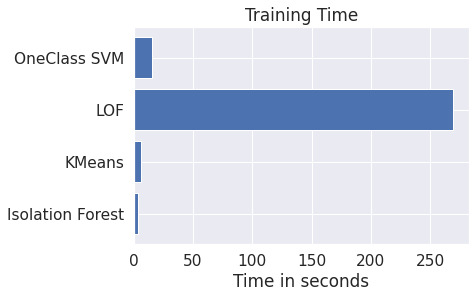

In [48]:
pyplot.title('Training Time')
pyplot.barh(range(len(train_times)), list(train_times.values()), align='center')
pyplot.yticks(range(len(train_times)), list(train_times.keys()))
pyplot.xlabel('Time in seconds')

Text(0.5, 0, 'Time in seconds')

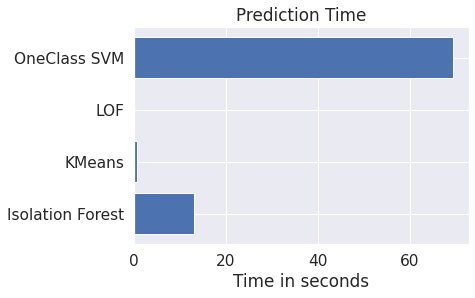

In [49]:
pyplot.title('Prediction Time')
pyplot.barh(range(len(prediction_times)), list(prediction_times.values()), align='center')
pyplot.yticks(range(len(prediction_times)), list(prediction_times.keys()))
pyplot.xlabel('Time in seconds')

The algorithm doesn't fare so well but this might be due to the over head of the ensemble structure.

In [50]:
## Performance Plot
auc_scores={
    'Isolation Forest': roc_auc_score(y_test, if_y_pred_class),
    'KMeans':roc_auc_score(y_test, km_y_pred),
    'LOF':roc_auc_score(y_test, lof_y_pred_class),
    'OneClass SVM': roc_auc_score(y_test, osvm_y_pred_class)
}

f1_scores={
    'Isolation Forest':f1_score(y_test, if_y_pred_class),
    'KMeans':f1_score(y_test, km_y_pred),
    'LOF':f1_score(y_test, lof_y_pred_class),
    'OneClass SVM': f1_score(y_test, osvm_y_pred_class)
}

Text(0.5, 0, 'AUC Score')

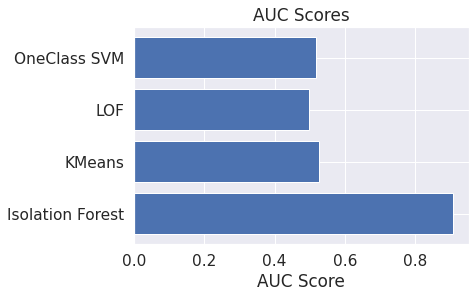

In [51]:
pyplot.title('AUC Scores')
pyplot.barh(range(len(auc_scores)), list(auc_scores.values()), align='center')
pyplot.yticks(range(len(auc_scores)), list(auc_scores.keys()))
pyplot.xlabel('AUC Score')

Text(0.5, 0, 'F1 Score')

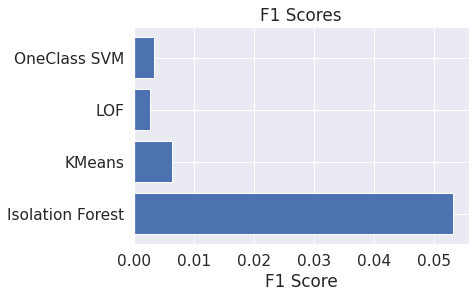

In [52]:
pyplot.title('F1 Scores')
pyplot.barh(range(len(f1_scores)), list(f1_scores.values()), align='center')
pyplot.yticks(range(len(f1_scores)), list(f1_scores.keys()))
pyplot.xlabel('F1 Score')

Coming to model performance, our isolation forest ensemble model is a clear winner!